# Árbol de clasificación: 

Árboles de decisión (Decision Tree) hace referencia a vari@s técnicas/algoritmos de aprendizaje supervisado usados para resolver problemas de clasificación y regresión.

Cada nodo del árbol es un atributo y cada nodo hoja es la categoría a la que se tomó la decisión. 

In [2]:
# Cargar librerias
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sb
 
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.model_selection import StratifiedKFold
# librerías Árboles de Decisión
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

# librerías Gaussian Naive Bayes
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import make_scorer

**¿Quién llegará al número uno en Billboard 100?**
A partir de atributos de cantantes y de un histórico de canciones que llegaron al top 100 de Billboard (U.S.) en 2013 y 2014, se creará un árbol de decisión que permita predecir si un nuevo cantante podrá llegar a la primera posición.

## 0. Pre procesamiento y exploración.

In [3]:
# carga de datos o teniendo el csv en la carpeta nube del colab.
billboardOriginal = pd.read_csv('billboard.csv')

In [4]:
#Para abrir desde colab sin tenerlo en la nube.
#from google.colab import files
#import io
#uploaded = files.upload()
#billboardOriginal = pd.read_csv(io.BytesIO(uploaded['billboard.csv']))

Datos de 635 artistas con 11 atributos

In [5]:
billboard = billboardOriginal.copy()
billboard.shape

(635, 11)

In [6]:
billboard.sample(5)

,id,title,artist,mood,tempo,genre,artist_type,chart_date,length_sec,top,year_of_birth
459,459,Have Yourself A Merry Little Christmas,SAM SMITH,Melancholy,Slow Tempo,Urban,Male,20141227,182,0,1992
129,129,My Baby's Gor A Smile On Her Face,CRAIG WAYNE BOYD,Yearning,Medium Tempo,Traditional,Male,20150103,178,0,1978
368,368,I Don't Fuck With You,BIG SEAN featuring E-40,Defiant,Medium Tempo,Urban,Male,20141011,248,0,0
618,618,How I Feel,FLO RIDA,Excited,Medium Tempo,Urban,Male,20140125,258,0,1979
525,525,Make It Rain,ED SHEERAN,Rowdy,Medium Tempo,Alternative & Punk,Male,20141220,220,0,1991


### **Variable objetivo:** ¿Cuántos alcanzaron el número 1?

De 23 tipos de "mood" hay 7 con mayor cantidad de datos, es decir, las canciones con estos estados de ánimo son mas propensas a entrar en el top 100:

 - Empowering
 - Cool
 - Energizing
 - Yeaning
 - Defiant
 - Excited
 - Sensual

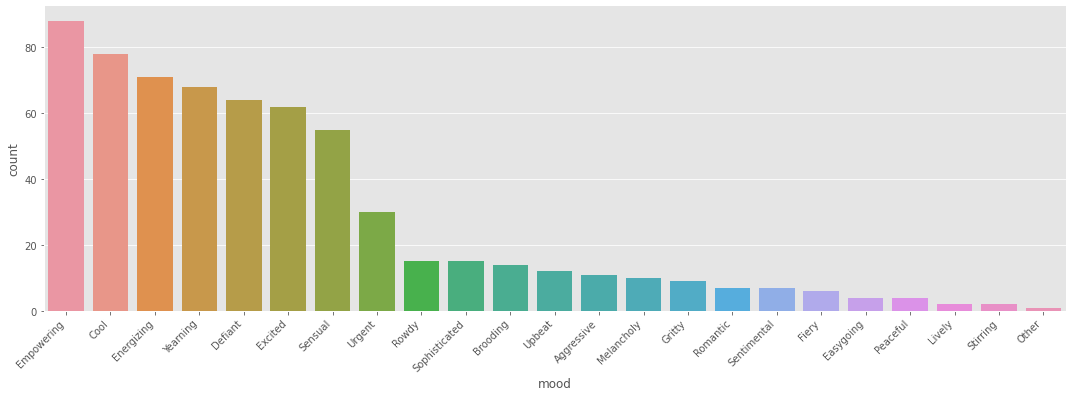

In [7]:
order = ['Empowering','Cool','Energizing','Yearning','Defiant','Excited',
         'Sensual','Urgent','Rowdy','Sophisticated','Brooding','Upbeat',
         'Aggressive','Melancholy','Gritty','Romantic','Sentimental','Fiery',
         'Easygoing','Peaceful','Lively','Stirring','Other']

g = sb.catplot(x='mood', data=billboard, kind="count", aspect=3, order=order)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right') 

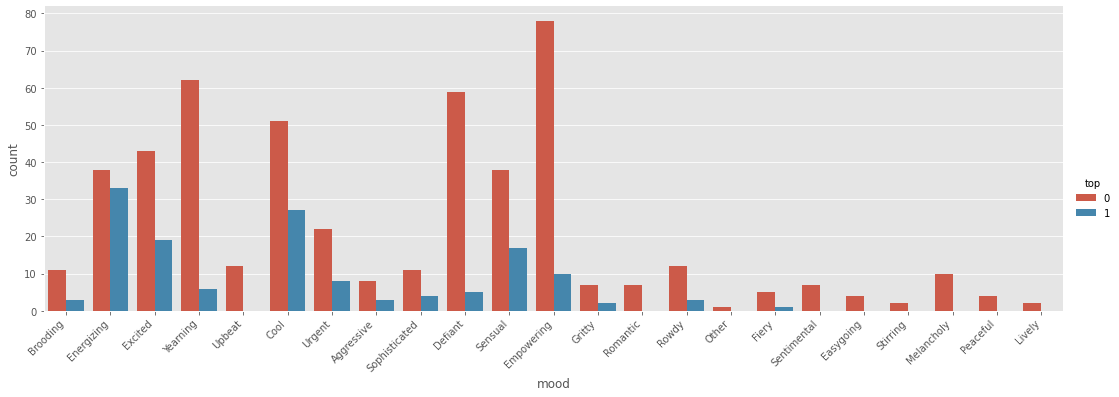

In [8]:
g = sb.catplot(x='mood', data=billboard, hue='top', kind="count", aspect=3)

for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right') 

Aún así se ve que los estados de ánimo "yearning", "defiant" y "empowering" son de los que menos canciones en top 1 han logrado colocar de estos 7, mientras que "cool" y "energizing" son de los que mas canciones en top 1 tuvieron.

In [9]:
billboard.groupby('top').size()

top
0    494
1    141
dtype: int64

**Variable objetivo**: 494 canciones no alcanzaron el top 1 (label 0) y 141 si lo hicieron (label 1).  Podemos observar que los datos están desbalanceados y esto puede sesgar el árbol.

En el siguiente gráfico se puede apreciar con mayor claridad.

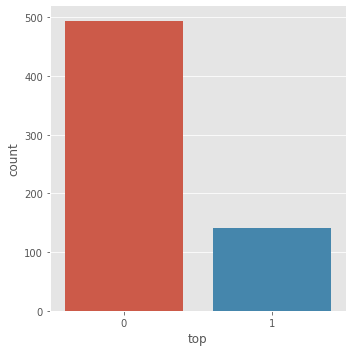

In [10]:
g = sb.catplot(x='top', data=billboard, kind="count")

**Variable Objetivo vs Datos:** Se evidencia que hay más del doble de artistas masculinos que femeninos, mientras que sólo hay alrededor de 100 canciones con artistas mixtos.

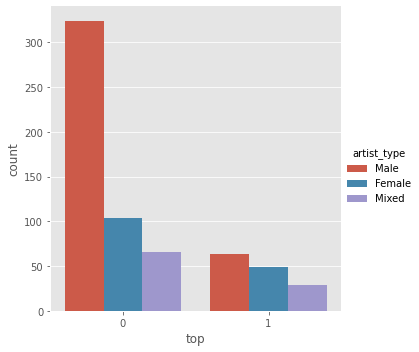

In [11]:
g = sb.catplot(x='top', data=billboard, hue='artist_type', kind="count")

La gran mayoría de las canciones con artistas hombres no alcanzaron el top 1 de Billboard (U.S.)

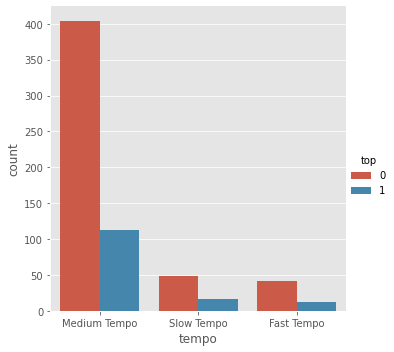

In [12]:
g = sb.catplot(x='tempo', data=billboard, hue='top', kind="count")

Observamos tres tipos de ritmo ("tempo"):

 - Medium
 - Slow
 - Fast

De estos tres el ritmo medio ha sido el que más canciones ha llevado tanto al top 100 como al top 1.

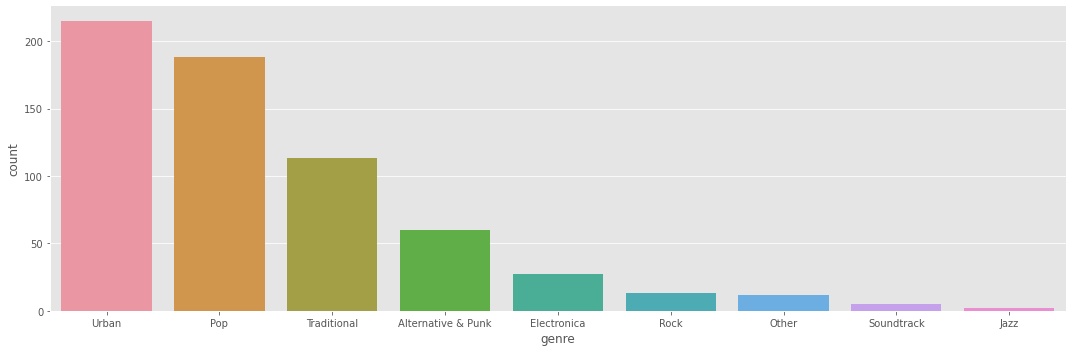

In [13]:
order = ['Urban','Pop','Traditional','Alternative & Punk','Electronica',
         'Rock','Other','Soundtrack','Jazz']
g = sb.catplot(x='genre', data=billboard, kind="count", aspect=3, order=order)

Comparando las canciones que llegaron al Top 1 y las que no

Buscamos si hay alguna relación evidente entre año de nacimiento y duración de Canción discriminando por color según la variable objetivo (por ahora ignoramos los artirtas de los cuales desconocemos su año de nacimiento).

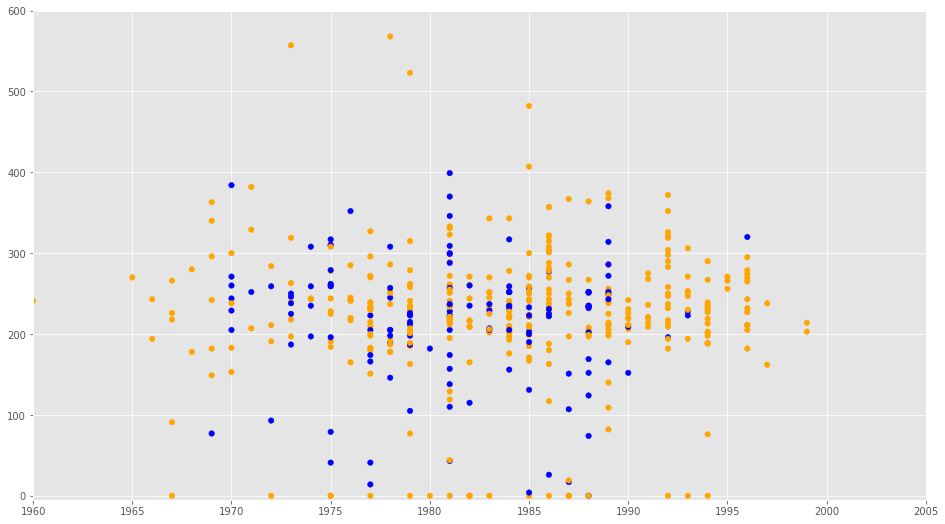

In [14]:
colors=['orange','blue']

f1 = billboard['year_of_birth'].values
f2 = billboard['length_sec'].values

asign=[]
for index, row in billboard.iterrows(): asign.append(colors[row['top']])

plt.scatter(f1, f2, c=asign, s=30)
plt.axis([1960,2005,-5,600])
plt.show()

No parece haber ningún patron aparente, están bastante mezclados los top y los no-top, pero vemos que para algunas canciones (exactamente 31) la duración es de cero segundos y tendremos que tratarla posteriormente.

In [15]:
irregular_songs = billboard['length_sec']
len(irregular_songs[irregular_songs<=0])

31

Variable Objetivo vs dato: Ahora veamos la distribución de los Top y no-Top según el año en que llegaron a la lista y la duración de la canción.

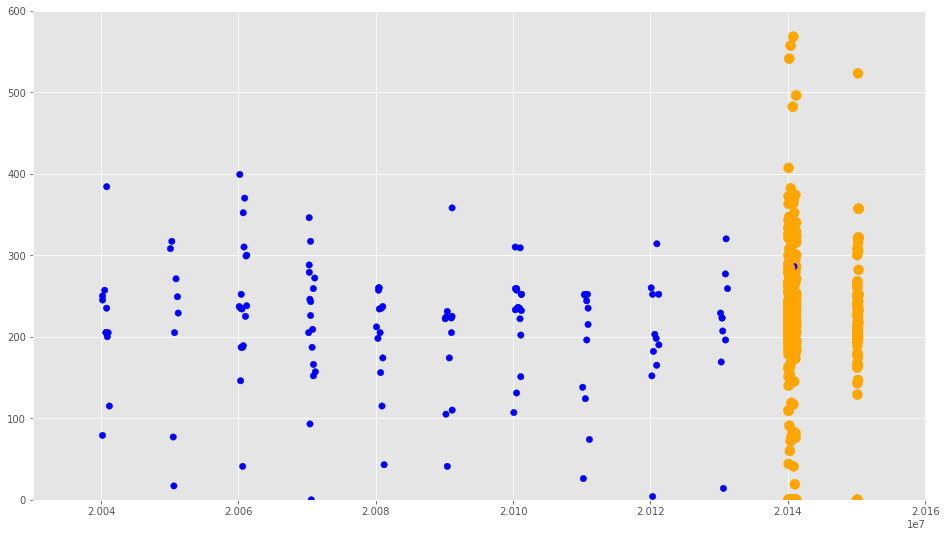

In [16]:
f1 = billboard['chart_date'].values
f2 = billboard['length_sec'].values
size=[100,40]
asign=[]
asign2=[]
for index, row in billboard.iterrows():    
    asign.append(colors[row['top']])
    asign2.append(size[row['top']])

plt.scatter(f1, f2, c=asign, s=asign2)
plt.axis([20030101,20160101,0,600])
plt.show()

Se puede ver que todos los no-Top (amarillos) estan concentrados en dos años, esto se debe a que los datos iniciales se tomaron en 2014 y 2015; había casi 500 registros que no llegaron a top 1 y sólo 11 que si.

Para intentar equilibrar un poco las clases se tomaron los datos de los artistas que llegaron al top 1 entre el 2004 y el 2013, pero aún así el desbalance sigue siendo bastante significativo.

Por lo tanto mas adelante se usará el parametro `class_weight` del modelo (árbol de decisión) para compensar la diferencia.

In [17]:
billboard.drop(['id','chart_date','top'], axis=1).describe()

,length_sec,year_of_birth
count,635.000000,635.000000
mean,321.768504,1548.590551
std,633.753787,820.470454
min,0.000000,0.000000
25%,200.000000,1969.000000
50%,232.000000,1981.000000
75%,266.500000,1986.000000
max,6840.000000,1999.000000


En el resumen estadístico podemos confirmar que tanto el año de nacimiento como la duración de algunas canciones toman valores de 0.

Según el género musical predominan el Urban y el Pop, seguidos por el Tradicional.

In [18]:
# borra registros duplicados por nombre para que la edad de cada artista aparezca solo una vez
unique_artists = billboard.drop_duplicates(billboard.columns[~billboard.columns.isin(['artist'])])

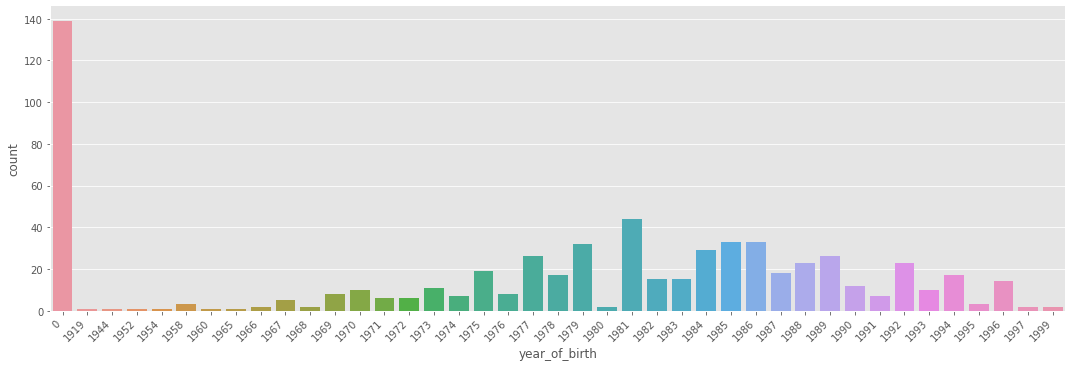

In [19]:
g = sb.catplot(x='year_of_birth', data=unique_artists, kind="count", aspect=3)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right') 

Hay aproximadamente 140 canciones cuyo cantante aparece como nacido en el año cero y esto no tiene mucho sentido.

In [20]:
birthsByYear = billboard['year_of_birth']
len(birthsByYear[birthsByYear<=0])

139

Hay exactamente 139 registros de canciones de las que desconocemos el año de nacimiento del artista. Se debe decidir cómo tratar estos ejemplos antes de proceder a entrenar el árbol.

### Manejo de las edades de los artistas

El objetivo de tener el año de nacimiento de los artistas es saber qué edad tenían al momento de entrar al top 100 de billboard.

Primero convertimos los valores de año de nacimiento cero y duración de canciones cero en NaN, así se pueden ignorar temporalmente y volver a realizar el resumen estadístico y los cálculos necesarios sin que se vean afectador por estos valores atípicos o errados.

In [21]:
# funcion auxiliar para convertir ceros en nan
def fix(predictor):
    if predictor == 0:
        return None
    return predictor

In [22]:
# reemplazo de ceros por nan
billboard['year_of_birth'] = billboard.apply(lambda x: fix(x['year_of_birth']), axis=1)
billboard['length_sec'] = billboard.apply(lambda x: fix(x['length_sec']), axis=1)

In [23]:
billboard.iloc[[4]]

,id,title,artist,mood,tempo,genre,artist_type,chart_date,length_sec,top,year_of_birth
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,NaN


In [24]:
billboard.iloc[[72]]

,id,title,artist,mood,tempo,genre,artist_type,chart_date,length_sec,top,year_of_birth
72,72,Style,TAYLOR SWIFT,Yearning,Medium Tempo,Pop,Female,20141115,NaN,0,1982.0


Visualizamos dos filas que previamente tenian valores de cero en las características de interes para corroborar que el cambio haya surtido efecto.

Realizamos el cálculo de la edad que tenian los artistas al entrar en la lista.

In [25]:
def age(year_of_birth, chart_date):
    chart_date = str(chart_date)
    chart_year = int(chart_date[:4])
    return chart_year - year_of_birth

In [26]:
billboard['age_on_billboard'] = billboard.apply(lambda x: age(x['year_of_birth'],x['chart_date']), axis=1);

añadimos la variable `age_on_billboard` al dataframe, que corresponde a la edad que tenía el artista al llegar al top 100 y eliminamos las columnas usadas para el cálculo.

In [27]:
billboard = billboard.drop(['year_of_birth','chart_date'], axis=1)

In [28]:
billboard.iloc[[4]]

,id,title,artist,mood,tempo,genre,artist_type,length_sec,top,age_on_billboard
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,232.0,0,NaN


Retificamos que los valores NaN no se ven afectados por las operaciones.

#### Calculamos el promedio de edad al llegar al top100 y de la duración, y reemplazamos los registros nulos

In [29]:
age_avg = billboard['age_on_billboard'].mean()
age_std = billboard['age_on_billboard'].std()
age_null_count = billboard['age_on_billboard'].isnull().sum()
# lista de valores aleatorios a partir de la media y la std
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)

withNullValues = np.isnan(billboard['age_on_billboard'])

billboard.loc[withNullValues, 'age_on_billboard'] = age_null_random_list
billboard['age_on_billboard'] = billboard['age_on_billboard'].astype(int)
print("Edad Promedio: " + str(age_avg))
print("Desviación Std Edad: " + str(age_std))
print("Intervalo para asignar edad aleatoria: " + str(int(age_avg - age_std)) + " a " + str(int(age_avg + age_std)))

Edad Promedio: 30.10282258064516
Desviación Std Edad: 8.40078832861513
Intervalo para asignar edad aleatoria: 21 a 38


In [30]:
dur_avg = billboard['length_sec'].mean()
# en este caso la desv est es tan alta que produce valores negativos,
# por tanto elegimos una cantidad arbitraria que no afecte la duración
dur_std = 60
dur_null_count = billboard['length_sec'].isnull().sum()
# lista de valores aleatorios a partir de la media y la std
dur_null_random_list = np.random.randint(dur_avg - dur_std, dur_avg + dur_std, size=dur_null_count)

nullValues = np.isnan(billboard['length_sec'])

billboard.loc[nullValues, 'length_sec'] = dur_null_random_list
print("Duración Promedio: " + str(dur_avg))
print("Margen Duración: " + str(dur_std))
print("Intervalo para asignar duración aleatoria: " + str(dur_avg - dur_std) + " a " + str(dur_avg + dur_std))

Duración Promedio: 338.2831125827815
Margen Duración: 60
Intervalo para asignar duración aleatoria: 278.2831125827815 a 398.2831125827815


In [31]:
billboard.iloc[[4]]

,id,title,artist,mood,tempo,genre,artist_type,length_sec,top,age_on_billboard
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,232.0,0,27


In [32]:
billboard.iloc[[72]]

,id,title,artist,mood,tempo,genre,artist_type,length_sec,top,age_on_billboard
72,72,Style,TAYLOR SWIFT,Yearning,Medium Tempo,Pop,Female,306.0,0,32


#### Visualizamos las edades y duraciones agregadas

In [33]:
billboard.describe()

,id,length_sec,top,age_on_billboard
count,635.000000,635.000000,635.000000,635.000000
mean,317.000000,338.379528,0.222047,29.883465
std,183.452991,629.598151,0.415950,7.771315
min,0.000000,4.000000,0.000000,15.000000
25%,158.500000,206.000000,0.000000,25.000000
50%,317.000000,235.000000,0.000000,29.000000
75%,475.500000,276.500000,0.000000,34.000000
max,634.000000,6840.000000,1.000000,95.000000


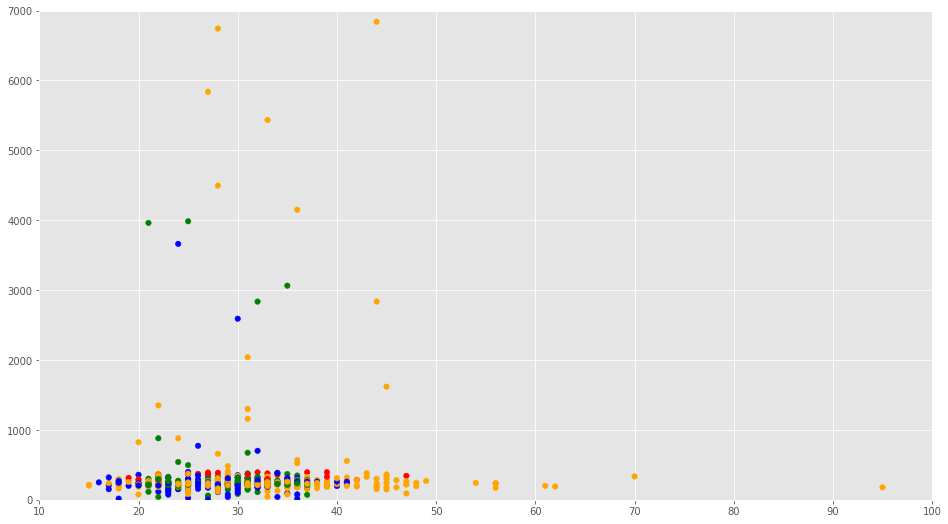

In [34]:
colors = ['orange','blue','green', 'red']

f1 = billboard['age_on_billboard'].values
f2 = billboard['length_sec'].values

asign=[]
for index, row in billboard.iterrows():
    # edades reemplazadas
    if (withNullValues[index]):
      asign.append(colors[2]) # verde
    # duraciones
    elif nullValues[index]:
      asign.append(colors[3]) # rojo
    else:
      asign.append(colors[row['top']])

plt.scatter(f1, f2, c=asign, s=30)
plt.axis([10,100,0,7000]) #650
plt.show()

Podemos ver que hay algunos valores bastante dispersos; lo ideal sería tratarlos de alguna forma, pero por ahora los dejaremos y acotaremos el grafico para ver la concentración un poco mejor.

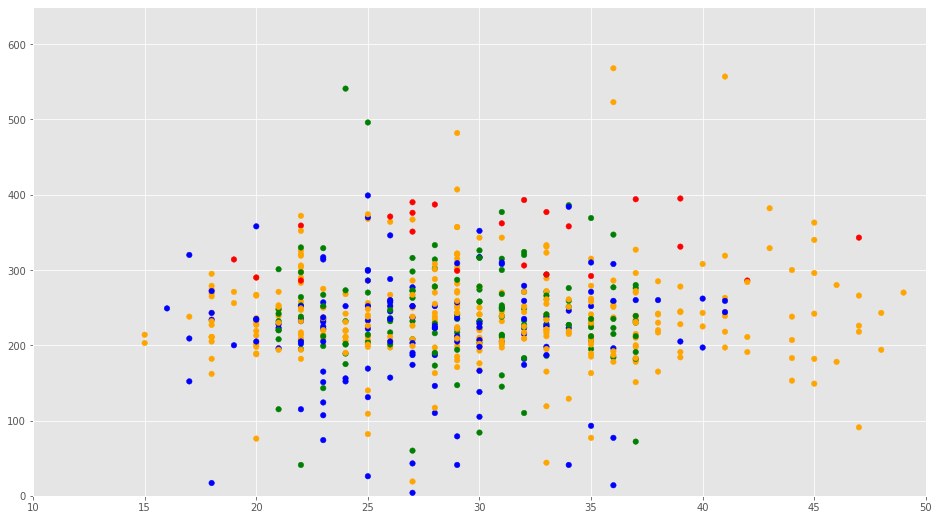

In [35]:
plt.scatter(f1, f2, c=asign, s=30)
plt.axis([10,50,0,650])
plt.show()

Graficando los artistas por edad y duración podemos ver en azul los que alcanzaron el top 1, mientras que los naranja son los que no llegaron, además, en verde vemos las edades y en rojo las duraciones que acabamos de llenar con el promedio.

### Mapeo de Atributos

Realizaremos un mapeo de los atributos de entrada para poder transformarlos a categorias que podamos utilzar en nuestro árbol de decisión.

Empezamos por ver las categorias y la cantidad de elementos en ellas.

In [36]:
def ver(variable):
  grouped11 = billboard.groupby(variable).size()
  neworder11 = grouped11.sort_values(ascending=False)
  print(neworder11)
  print()

print("Estados de animo:")
ver('mood')

print("Ritmos de Canción:")
ver('tempo')

print("Genero:")
ver('genre')

print("Tipos de Artista:")
ver('artist_type')

Estados de animo:
mood
Empowering       88
Cool             78
Energizing       71
Yearning         68
Defiant          64
Excited          62
Sensual          55
Urgent           30
Rowdy            15
Sophisticated    15
Brooding         14
Upbeat           12
Aggressive       11
Melancholy       10
Gritty            9
Romantic          7
Sentimental       7
Fiery             6
Peaceful          4
Easygoing         4
Lively            2
Stirring          2
Other             1
dtype: int64

Ritmos de Canción:
tempo
Medium Tempo    517
Slow Tempo       65
Fast Tempo       53
dtype: int64

Genero:
genre
Urban                 215
Pop                   188
Traditional           113
Alternative & Punk     60
Electronica            27
Rock                   13
Other                  12
Soundtrack              5
Jazz                    2
dtype: int64

Tipos de Artista:
artist_type
Male      387
Female    153
Mixed      95
dtype: int64



Ahora pasaremos de tener 23 estados de animo a tener 7 agrupando moods que puedan resultar similares

In [37]:
# Mood Mapping 
billboard['moodEncoded'] = billboard['mood'].map( {'Energizing': 6, 
                                        'Empowering': 6,
                                        'Cool': 5, 
                                        'Yearning': 4, #anhelo, deseo, ansia
                                        'Excited': 5, #emocionado
                                        'Defiant': 3, 
                                        'Sensual': 2, 
                                        'Gritty': 3, #coraje 
                                        'Sophisticated': 1,
                                        'Aggressive': 4, #provocativo
                                        'Fiery': 4, #caracter fuerte
                                        'Urgent': 3, 
                                        'Rowdy': 4, #ruidoso
                                        'Sentimental': 4,
                                        'Easygoing': 1, #sencillo
                                        'Melancholy': 4, 
                                        'Romantic': 2, 
                                        'Peaceful': 1, 
                                        'Brooding': 4, #melancolico
                                        'Upbeat': 5, #optimista alegre
                                        'Stirring': 5, #emocionante
                                        'Lively': 5, #animado
                                        'Other': 0,
                                        '': 0}).astype(int)

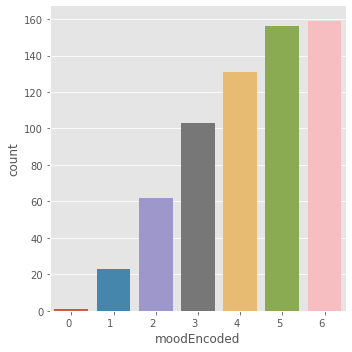

In [38]:
g = sb.catplot(x='moodEncoded', data=billboard, kind="count")
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=0, horizontalalignment='right') 

esto se hace asignando valores entre 0 y 6, según su similitud (se pueden agrupar diferente si lo considera conveniente)

In [39]:
# Tempo Mapping 
billboard['tempoEncoded'] = billboard['tempo'].map( {
    'Fast Tempo': 0, 
    'Medium Tempo': 2, 
    'Slow Tempo': 1, 
    '': 0} ).astype(int)

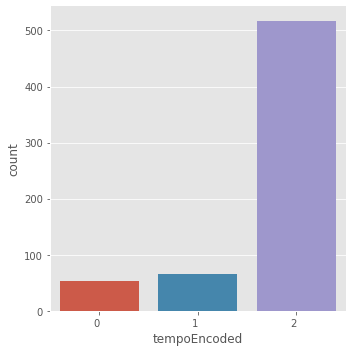

In [40]:
g = sb.catplot(x='tempoEncoded', data=billboard, kind="count")
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), horizontalalignment='right') 

Se codifica el ritmo con valores entre 0 y 2 de acuerdo a la cantidad de canciones que tiene cada "tempo".

In [41]:
# Genre Mapping 
billboard['genreEncoded'] = billboard['genre'].map( {'Urban': 4, 
                                          'Pop': 3, 
                                          'Traditional': 2, 
                                          'Alternative & Punk': 1,
                                          'Electronica': 1, 
                                          'Rock': 1, 
                                          'Soundtrack': 0, 
                                          'Jazz': 0,
                                          'Other':0,'':0} 
                                       ).astype(int)

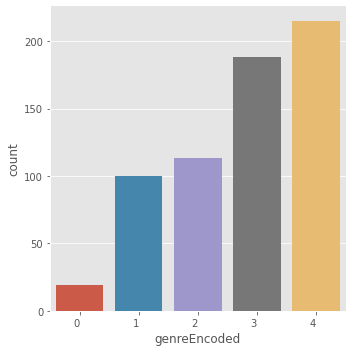

In [42]:
g = sb.catplot(x='genreEncoded', data=billboard, kind="count")
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), horizontalalignment='right') 

Agrupandolos también por similaridad del género pasamos de 9 a 5 categorias.



In [43]:
# artist_type Mapping 
billboard['artist_typeEncoded'] = billboard['artist_type'].map( {
    'Female': 2, 
    'Male': 3, 
    'Mixed': 1, 
    '': 0} ).astype(int)

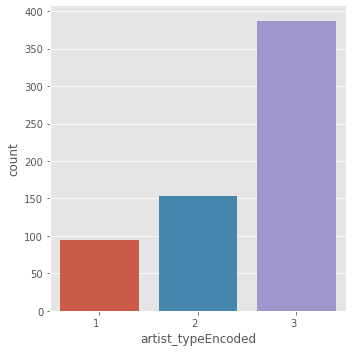

In [44]:
g = sb.catplot(x='artist_typeEncoded', data=billboard, kind="count")
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), horizontalalignment='right') 

Dando valores entre 0 y 3 de acuerdo con el tipo de artista

In [45]:
# Mapping edad en la que llegaron al billboard
billboard_edad = billboard['age_on_billboard']

billboard.loc[ billboard_edad <= 21, 'edadEncoded']	= 0
billboard.loc[(billboard_edad > 21) & (billboard_edad <= 26), 'edadEncoded'] = 1
billboard.loc[(billboard_edad > 26) & (billboard_edad <= 30), 'edadEncoded'] = 2
billboard.loc[(billboard_edad > 30) & (billboard_edad <= 40), 'edadEncoded'] = 3
billboard.loc[ billboard_edad > 40, 'edadEncoded'] = 4

In [46]:
billboard['edadEncoded'] = billboard['edadEncoded'].astype(int)

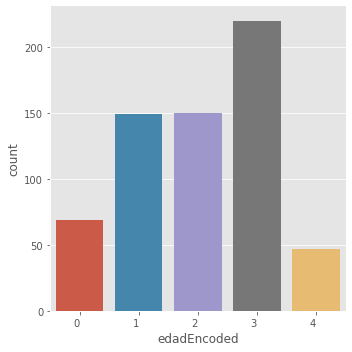

In [47]:
g = sb.catplot(x='edadEncoded', data=billboard, kind="count")
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), horizontalalignment='right') 

Cambiando por rangos entre 0 y 4:
   - Menor o igual que 21 años = 0
   - Mayor a 21 y menor o igual que 26 = 1
   - Mayor a 26 y menor o igual que 30 = 2
   - Mayor a 30 y menor o igual que 40 = 3
   - Mayor a 40 = 4

In [48]:
# Mapping Song Duration
billboard_seg = billboard['length_sec']
billboard.loc[ billboard_seg <= 150, 'durationEncoded']	= 0
billboard.loc[(billboard_seg > 150) & (billboard_seg <= 180), 'durationEncoded'] = 1
billboard.loc[(billboard_seg > 180) & (billboard_seg <= 210), 'durationEncoded'] = 2
billboard.loc[(billboard_seg > 210) & (billboard_seg <= 240), 'durationEncoded'] = 3
billboard.loc[(billboard_seg > 240) & (billboard_seg <= 270), 'durationEncoded'] = 4
billboard.loc[(billboard_seg > 270) & (billboard_seg <= 300), 'durationEncoded'] = 5
billboard.loc[ billboard_seg > 300, 'durationEncoded'] = 6

In [49]:
billboard['durationEncoded'] = billboard['durationEncoded'].astype(int)

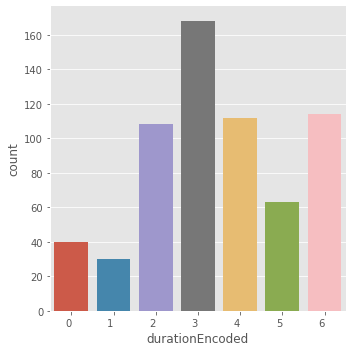

In [50]:
g = sb.catplot(x='durationEncoded', data=billboard, kind="count")
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), horizontalalignment='right') 

Y de la misma manera para la duración de la canción en segundos

In [51]:
drop_elements = ['id',
                 'title',
                 'artist',
                 'mood',
                 'tempo',
                 'genre',
                 'artist_type',
                 'length_sec',
                 'age_on_billboard'
                ]
artists_encoded = billboard.drop(drop_elements, axis = 1)

#### Ahora que tenemos todo codificado nos deshacemos de la información que no nos es de utilidad para entrenar el modelo.


In [52]:
artists_encoded.sample(8)

,top,moodEncoded,tempoEncoded,genreEncoded,artist_typeEncoded,edadEncoded,durationEncoded
110,0,6,2,3,1,3,4
199,0,4,2,4,3,1,6
129,0,4,2,2,3,3,1
542,0,5,2,4,2,3,4
319,0,3,2,4,3,2,0
132,1,6,2,4,3,3,2
379,0,6,1,1,2,2,1
458,0,3,2,2,3,2,0


### Variable objetivo vs datos: ¿Cómo quedan los top en relacion con los datos mapeados?

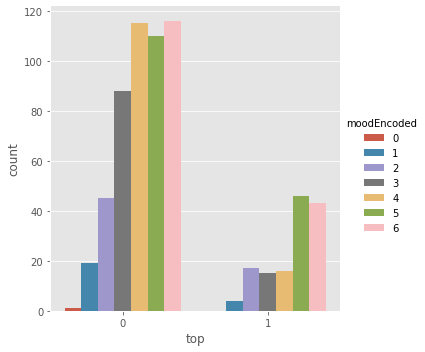

In [53]:
g = sb.catplot(x='top', data=artists_encoded, hue='moodEncoded', kind="count")

In [54]:
artists_encoded[['moodEncoded', 'top']].groupby(['moodEncoded'], as_index=False).agg(['count', 'sum'])

top    
            count sum
moodEncoded          
0               1   0
1              23   4
2              62  17
3             103  15
4             131  16
5             156  46
6             159  43

La mayoría de los top 1 están en el "mood" 5 y 6  con 46 y 43 canciones

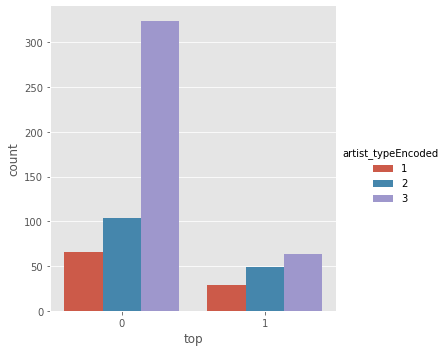

In [55]:
g = sb.catplot(x='top', data=artists_encoded, hue='artist_typeEncoded', kind="count")

In [56]:
artists_encoded[['artist_typeEncoded', 'top']].groupby(['artist_typeEncoded'], as_index=False).agg(['count', 'sum'])

top    
                   count sum
artist_typeEncoded          
1                     95  29
2                    153  49
3                    387  63

Hay una "buena" distribución de datos aunque se ve que mayormente están en los artistas de tipo 3 (Masculinos)

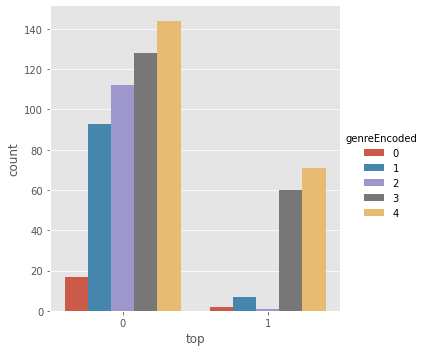

In [57]:
g = sb.catplot(x='top', data=artists_encoded, hue='genreEncoded', kind="count")

In [58]:
artists_encoded[['genreEncoded', 'top']].groupby(['genreEncoded'], as_index=False).agg(['count', 'sum'])

top    
             count sum
genreEncoded          
0               19   2
1              100   7
2              113   1
3              188  60
4              215  71

Como era de esperarse la mayoría de los top estan en los genero 3 y 4 que son Urbano y Pop

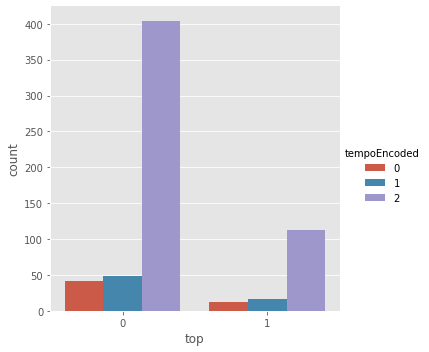

In [59]:
g = sb.catplot(x='top', data=artists_encoded, hue='tempoEncoded', kind="count")

In [60]:
artists_encoded[['tempoEncoded', 'top']].groupby(['tempoEncoded'], as_index=False).agg(['count', 'sum'])

top     
             count  sum
tempoEncoded           
0               53   12
1               65   16
2              517  113

De la misma manera el "tempo" con mas canciones en el top 1 es el 2, tempo medio

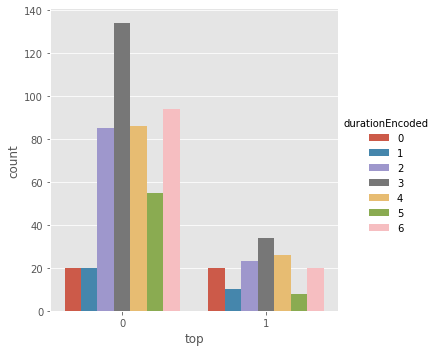

In [61]:
g = sb.catplot(x='top', data=artists_encoded, hue='durationEncoded', kind="count")

In [62]:
artists_encoded[['durationEncoded', 'top']].groupby(['durationEncoded'], as_index=False).agg(['count', 'sum'])

top    
                count sum
durationEncoded          
0                  40  20
1                  30  10
2                 108  23
3                 168  34
4                 112  26
5                  63   8
6                 114  20

Respecto a la duración de las canciones están bastante repartidas aunque se ve una mayoría en la duracion 3

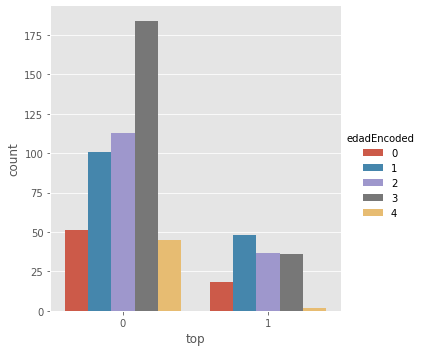

In [63]:
g = sb.catplot(x='top', data=artists_encoded, hue='edadEncoded', kind="count")

In [64]:
artists_encoded[['edadEncoded', 'top']].groupby(['edadEncoded'], as_index=False).agg(['count', 'sum'])

top    
            count sum
edadEncoded          
0              69  18
1             149  48
2             150  37
3             220  36
4              47   2

La mayoría de los artistas que logran llevar una canción al Top 1 están en el rango 1, que corresponde a edades entre 21 y 25 años

## 1. Característica objetivo.

### Buscamos nuestro Arbol de Decisión

K-Fold permite partir los datos en k folds consecutivos. Cada fold es usado una vez como conjunto de validación mientras que los k-1 restantes forman el conjunto de entrenamiento. Esto permite usar todos los datos para “tunear” los hiper parámetros del árbol (profundidad, minimo de muestras en una hoja...) y evitar el desperdicio de información al crear un conjunto de validación (solo se dividen en datos de entrenamiento y prueba).

Como estamos ante una tarea de clasificación y no de regresión, usamos de la libreria sklearn tree.DecisionTreeClassifier:

 - criterion: se puede elegir entre "entropy" (ganancia de infromación) o gini.
 - min_samples_split: cantidad mínima de muestras que debe tener un nodo para subdividirse
 - min_samples_leaf:  cantidad mínima de muestras que debe tener un nodo hoja
 - class_weight: compensa de cierta manera el desbalance de clases (top 0 [494] dividido entre los top 1 [141] da 3.5)

todos estos parametros salen de prueba y error, visualizar los datos y el arbol y volver a intentar.


In [65]:
#Mezclar datos
artists_encoded=artists_encoded.sample(frac=1).reset_index(drop=True)

X = artists_encoded.drop(['top'], axis=1)
y = artists_encoded['top'] 

In [66]:
X = np.array(X)
y = np.array(y)

#### Entropy

In [67]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1) # Numero de "folds: Subconjuntos" en que se dividen los datos de entrenamiento,
                                                                # Lo prueba con n-1 holds restantnes,
accuracies = list()
max_attributes = len(list(artists_encoded))
depth_range = range(1, max_attributes + 1)

# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight={0:1, 1:3.5}) # Por defecto todas las clases tienen peso 1
                                                                        # tambien se puede usar 'balanced'
    for train_index, valid_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[valid_index]    #Validación cruzada.
        y_train, y_test = y[train_index], y[valid_index]

        model = tree_model.fit(X_train, y_train)
        valid_acc = model.score(X_test, y_test) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    # almacenamos acc promedio para cada profundidad
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.555952
         2          0.555952
         3          0.574678
         4          0.573239
         5          0.650422
         6          0.647173
         7          0.637674


#### Gini

In [68]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1) # Numero de "folds: Subconjuntos" en que se dividen los datos de entrenamiento,
                                                                # Lo prueba con n-1 holds restantnes,
accuracies = list()
max_attributes = len(list(artists_encoded))
depth_range = range(1, max_attributes + 1)

# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='gini',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight={0:1, 1:3.5}) # Por defecto todas las clases tienen peso 1
                                                                        # tambien se puede usar 'balanced'
    for train_index, valid_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[valid_index]    #Validación cruzada.
        y_train, y_test = y[train_index], y[valid_index]

        model = tree_model.fit(X_train, y_train)
        valid_acc = model.score(X_test, y_test) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    # almacenamos acc promedio para cada profundidad
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.555952
         2          0.555952
         3          0.588715
         4          0.598388
         5          0.648834
         6          0.650298
         7          0.653398


<center>

¿Con cuál ocurren mejores desempeño de exactitud?
</center>

## 2. Datos de entrenamiento y prueba.

In [69]:
# Dividimos los datos para entrenamiento y prueba
X = artists_encoded.drop(['top'], axis=1)
y = artists_encoded['top']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,    #80% entrenamineto, 20% prueba 
                                                    stratify = y,
                                                    random_state = 1)

In [70]:
conteo = X_train.copy()
conteo['label'] = y_train
conteo.groupby('label').size()

label
0    395
1    113
dtype: int64

In [71]:
w = 395/113 #Creando los pesos con respecto a la clase con mayor tamaño de datos
w

3.495575221238938

## 3. ¿Qué variables usar en la clasificación?

### Gráfica de correlación de Pearson

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

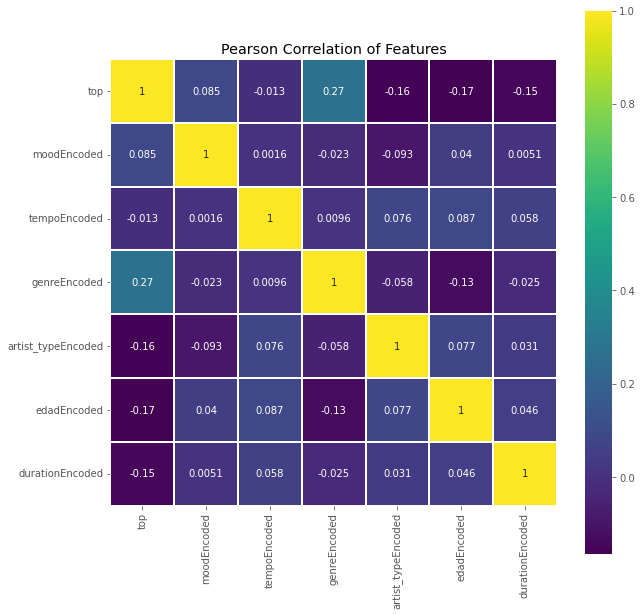

In [72]:
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features')
sb.heatmap(artists_encoded.astype(float).corr(),
           vmax=1.0,
           cmap=colormap,
           annot=True,
           linewidths=0.1,
           linecolor='white',
           square=True)

### Matriz de correlación de Cramer V
Para datos categóricos

In [73]:
data_encoded = artists_encoded.copy()

In [74]:
from scipy.stats import chi2_contingency

def cramers_V(var1, var2):
  crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))
  stat = chi2_contingency(crosstab)[0]
  obs = np.sum(crosstab)
  mini = min(crosstab.shape) - 1
  return (stat/(obs*mini))

In [75]:
rows= []

for var1 in data_encoded:
  col = []
  for var2 in data_encoded :
    cramers =cramers_V(data_encoded[var1], data_encoded[var2])
    col.append(round(cramers,2))
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)


df

,top,moodEncoded,tempoEncoded,genreEncoded,artist_typeEncoded,edadEncoded,durationEncoded
top,0.99,0.03,0.00,0.11,0.03,0.04,0.04
moodEncoded,0.03,1.00,0.05,0.05,0.01,0.01,0.01
tempoEncoded,0.00,0.05,1.00,0.01,0.00,0.01,0.02
genreEncoded,0.11,0.05,0.01,1.00,0.05,0.03,0.01
artist_typeEncoded,0.03,0.01,0.00,0.05,1.00,0.02,0.01
edadEncoded,0.04,0.01,0.01,0.03,0.02,1.00,0.01
durationEncoded,0.04,0.01,0.02,0.01,0.01,0.01,1.00


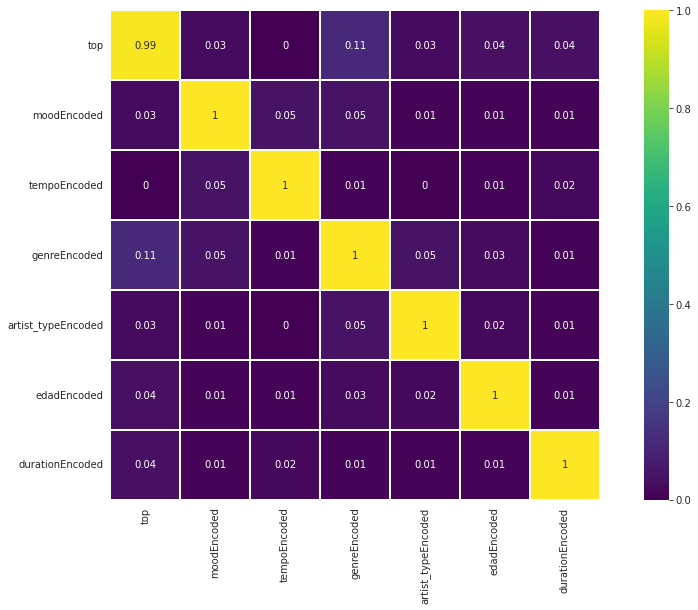

In [76]:
with sb.axes_style("white"):
  ax = sb.heatmap(df,
                  vmin=0.,
                  vmax=1,
                  cmap=colormap,
                  annot=True,
                  linewidths=0.1,
                  square=True)

plt.show()

### SelectKBest: ¿Qué variables tienen mayor impacto qué otras a la variable objetivo?

In [77]:
#Mezclar datos, aunque ya se mezclaron mas arriba
artists_encoded=artists_encoded.sample(frac=1).reset_index(drop=True)

#Todos los datos excepto la caracteristica objetivo.
X = artists_encoded.drop(['top'], axis=1)

#CARACTERÍSTICA OBJETIVO
y = artists_encoded['top']
 
best=SelectKBest(k=5)

X_new = best.fit_transform(X, y)
X_new.shape
selected = best.get_support(indices=True)
print(X.columns[selected])

Index(['moodEncoded', 'genreEncoded', 'artist_typeEncoded', 'edadEncoded',
       'durationEncoded'],
      dtype='object')


Según esta gráfica la correlación entre variables es mínima, por lo que usarlas todas en nuestro modelo nos aportará información

## 4. Exactitud con diferentes alturas del árbol
## 5. Exactitud con diferentes nodos y hojas.

Tener en cuenta el supuesto de que los árboles de decisión creen que el número de clases está balanceado. Por ende, se debe balancear.

In [78]:
conteo = X_train.copy()
conteo['label'] = y_train
conteo.groupby('label').size()

label
0    395
1    113
dtype: int64

In [79]:
w = 395/113   #Creando los pesos con respecto a la clase con mayor tamaño de datos
w

3.495575221238938

In [80]:
# Instanciar Arbol de decision con profundidad = 5
decision_tree = tree.DecisionTreeClassifier(criterion='gini',
                                            #Restricciones que evitan Overfitting.
                                            min_samples_split=25, #5. Qué pasa si varió el número de muestras mínimo por nodo.
                                            min_samples_leaf=6,   #5. Qué pasa si vario el número de muestras mínimo por hoja (Las hojas es el nodo final del).
                                            max_depth = 6,    #4. Testear qué pasa si aumento o disminuyo la altura del arbol.
                                                              #Tener en cuenta que la altura va desde 1 hasta el número de atributos (Variables).
                                            class_weight='balanced')  #Balanceo automático
                                            #class_weight={0:1, 1:w})


In [81]:
# Ajustamos el modelo con los datos
decision_tree.fit(X_train, y_train)

#Cada cambio que se haga requiere analizar o tener en cuenta su nivel de exactitud.

#Exactitud

#Datos de entrenamiento
y_pred_train = decision_tree.predict(X_train)

#Porcentaje de exactitud con los datos de entrenamiento
acc_train = accuracy_score(y_train, y_pred_train)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train))

#Datos de prueba
y_pred_test = decision_tree.predict(X_test)

#Porcentaje de exactitud con pruebas
acc_test = accuracy_score(y_test, y_pred_test)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test))  

Exactitud con datos de entrenamiento: 0.66
Exactitud con datos de pruebas: 0.57


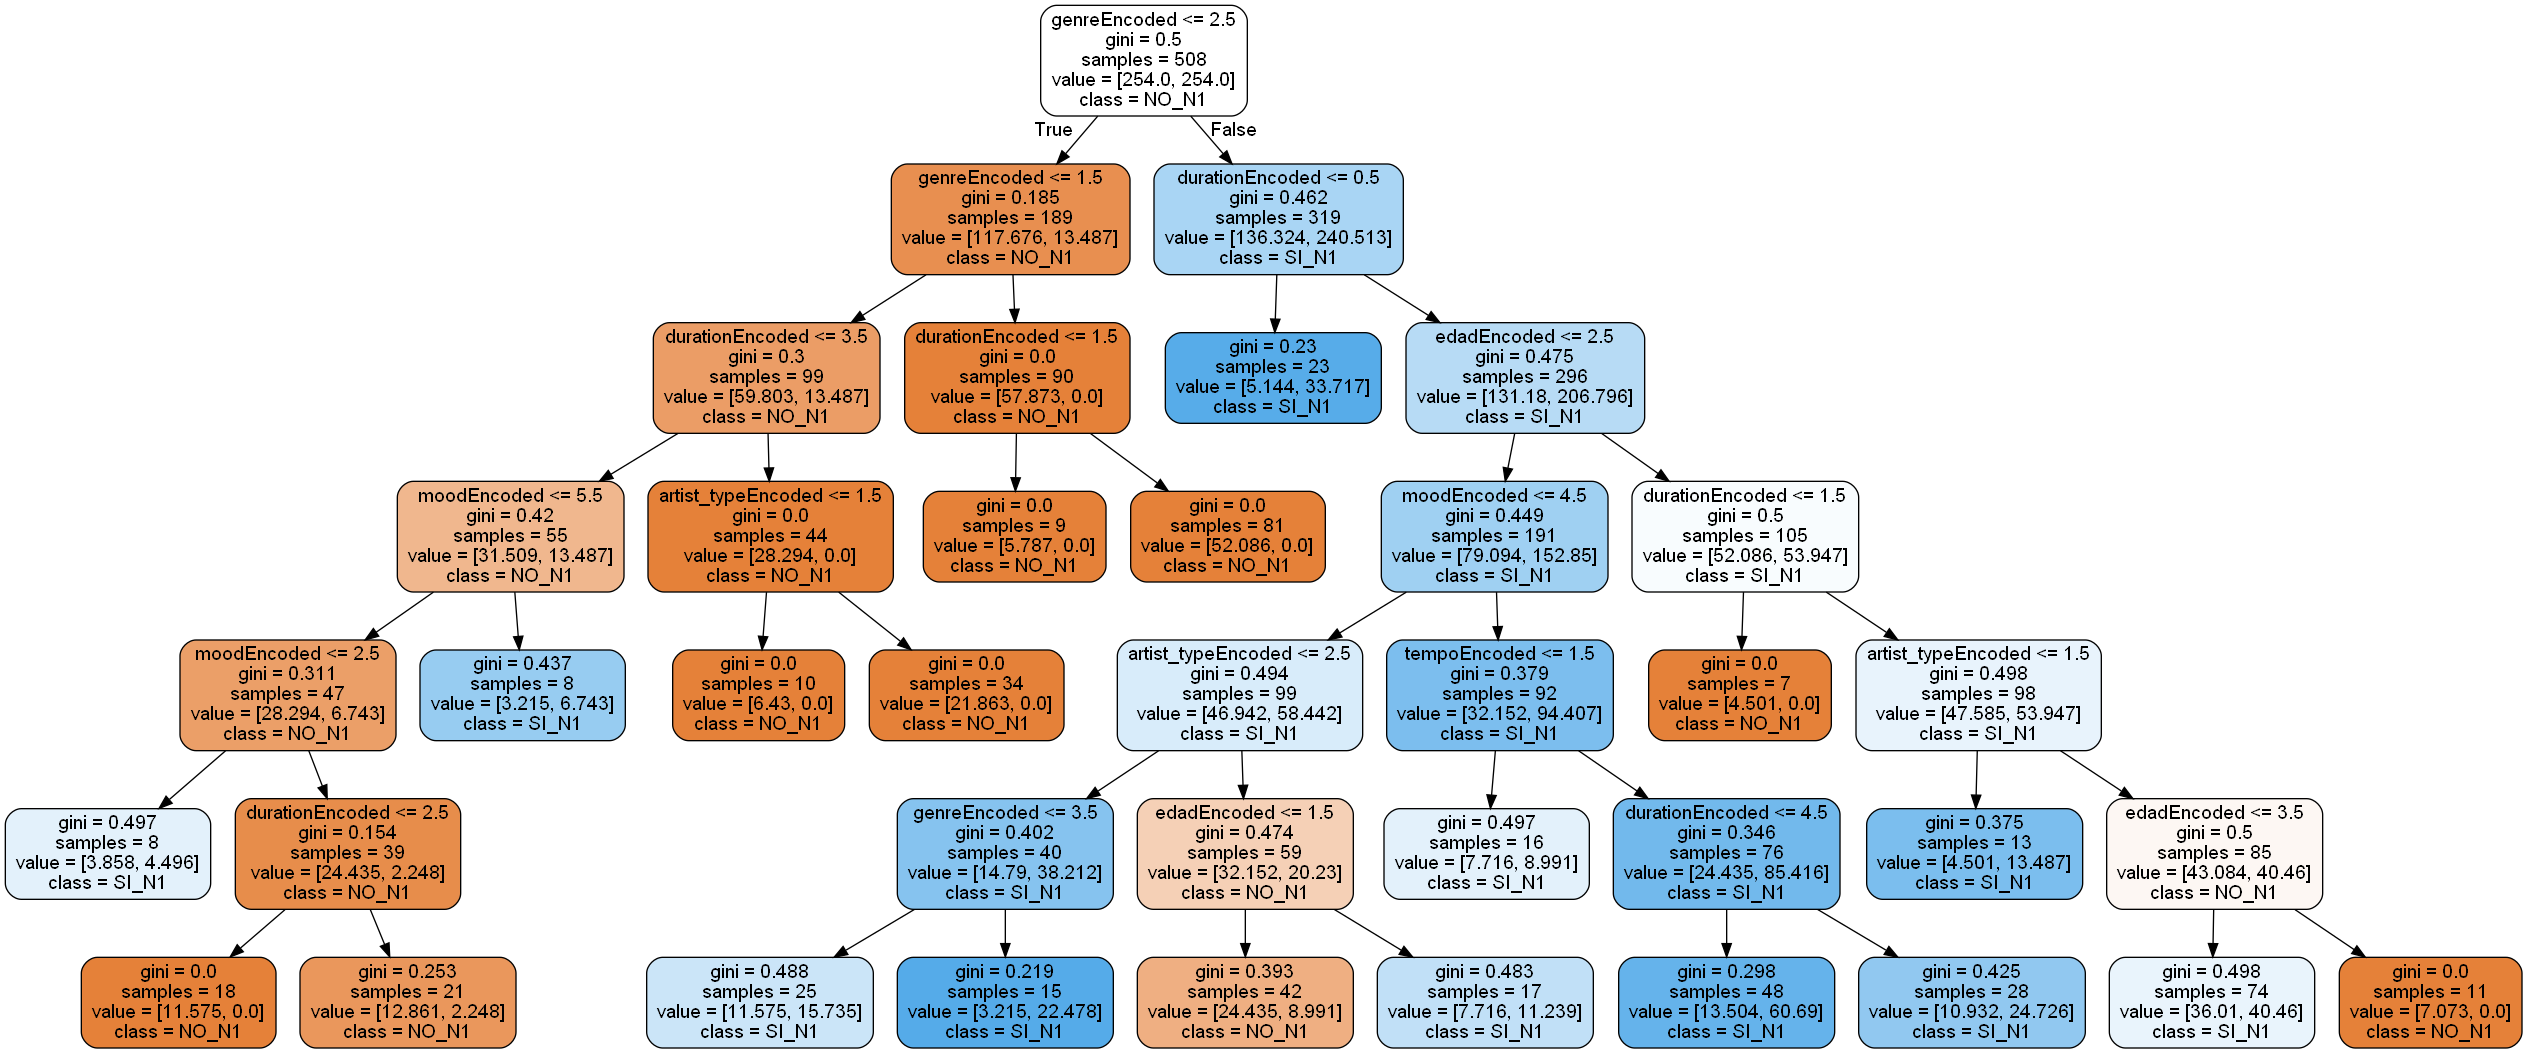

In [82]:
# exportar el modelo a archivo .dot y graficar
with open(r"tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 6,
                              impurity = True,
                              feature_names = list(artists_encoded.drop(['top'], axis=1)),
                              class_names = ['NO_N1', 'SI_N1'],
                              rounded = True,
                              filled= True )
        
# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
PImage("tree1.png")

## 6. Métricas:

### Matriz de confusión.
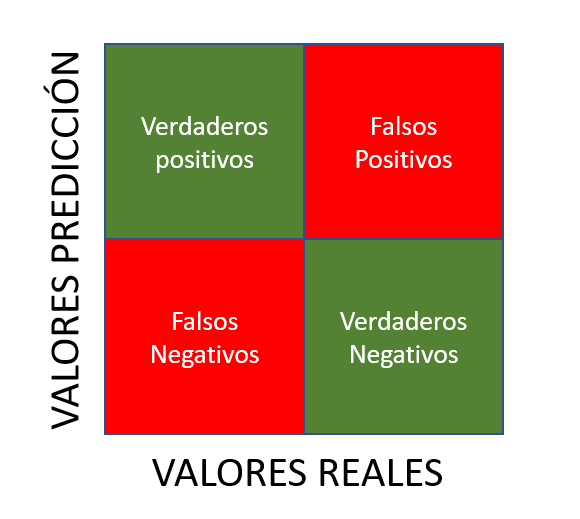

#### Datos de entrenamiento.

c:\Users\User\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


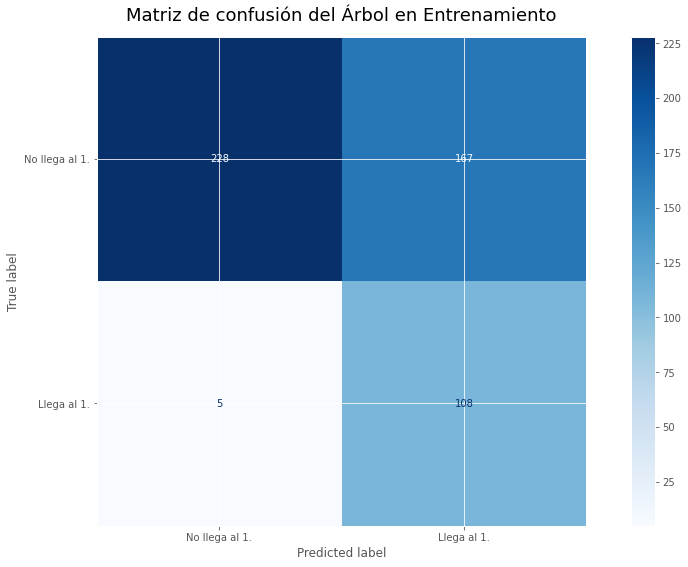

In [83]:
#Matriz de confuncion para Test
disp = plot_confusion_matrix(decision_tree, X_train, y_train,
                                 display_labels=['No llega al 1.','Llega al 1.'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Matriz de confusión del Árbol en Entrenamiento', y=1.02, size=18)

plt.show()

#### Datos de prueba

c:\Users\User\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


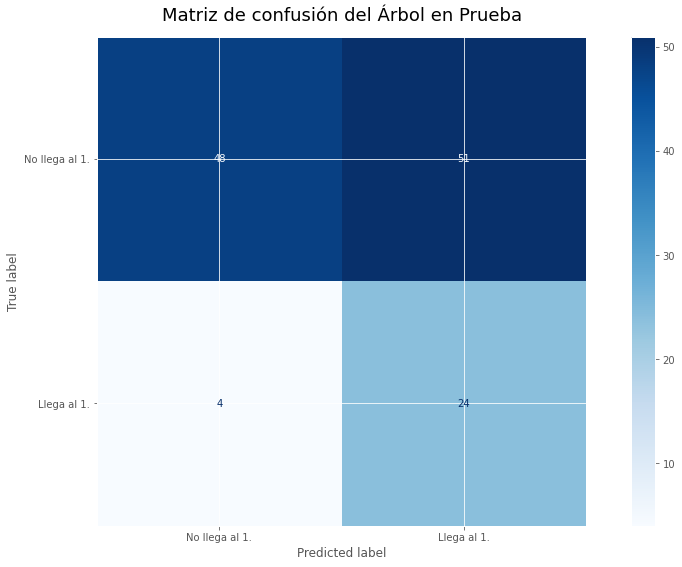

In [84]:
#Matriz de confuncion para Test
disp = plot_confusion_matrix(decision_tree, X_test, y_test,
                                 display_labels=['No llega al 1.','Llega al 1.'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Matriz de confusión del Árbol en Prueba', y=1.02, size=18)

plt.show()

### Exactitud del árbol con datos de entrenamiento

In [85]:
y_pred_train = decision_tree.predict(X_train)

In [86]:
acc_train = accuracy_score(y_train, y_pred_train)
print("Train set accuracy: {:.2f}".format(acc_train))

Train set accuracy: 0.66


### Exactitud del árbol con datos de prueba

In [87]:
y_pred_test = decision_tree.predict(X_test)

In [88]:
acc_test = accuracy_score(y_test, y_pred_test)
print("Test set accuracy: {:.2f}".format(acc_test))

Test set accuracy: 0.57


### F1-Score, precision, recall

#### Datos de entrenamiento

In [89]:
decoded_y_test = y_train
decoded_predictions = decision_tree.predict(X_train)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test,
                            decoded_predictions))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.98      0.58      0.73       395
           1       0.39      0.96      0.56       113

    accuracy                           0.66       508
   macro avg       0.69      0.77      0.64       508
weighted avg       0.85      0.66      0.69       508



#### Datos de prueba

In [90]:
decoded_y_test = y_test
decoded_predictions = decision_tree.predict(X_test)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test,
                            decoded_predictions))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.92      0.48      0.64        99
           1       0.32      0.86      0.47        28

    accuracy                           0.57       127
   macro avg       0.62      0.67      0.55       127
weighted avg       0.79      0.57      0.60       127



### Predicción del árbol de decisión

In [91]:
#predecir artista CAMILA CABELLO featuring YOUNG THUG
# con su canción Havana llego a numero 1 Billboard US en 2017

x_test = pd.DataFrame(columns=('top','moodEncoded', 'tempoEncoded', 'genreEncoded','artist_typeEncoded','edadEncoded','durationEncoded'))
x_test.loc[0] = (1,5,2,4,1,0,3)
y_pred = decision_tree.predict(x_test.drop(['top'], axis = 1)) #Saca el top: Característica objetivo
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['top'], axis = 1))
print("Probabilidad de Acierto: " + str(np.round(y_proba[0][y_pred]* 100, 2)) + "%")

Prediccion: [1]
Probabilidad de Acierto: [81.8]%


In [92]:
#predecir artista Imagine Dragons 
# con su canción Believer llego al puesto 42 Billboard US en 2017

x_test = pd.DataFrame(columns=('top','moodEncoded', 'tempoEncoded', 'genreEncoded','artist_typeEncoded','edadEncoded','durationEncoded'))
x_test.loc[0] = (0,4,2,1,3,2,3)
y_pred = decision_tree.predict(x_test.drop(['top'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['top'], axis = 1))
print("Probabilidad de Acierto: " + str(np.round(y_proba[0][y_pred]* 100, 2))+"%")

Prediccion: [0]
Probabilidad de Acierto: [85.12]%


# Clasificación Bayesiana 1.
Se realizaron todos los preprocesamientos para aplicar los métodos.
SUPUESTOS (Ingenuidad): Para que los cálculos sean ligeros

- Los datos que se van a tratar provienen de una distribución Gaussiana.
- Los datos son independientes entre sí, es decir, cada una de forma individual aporta a la variable objetivo (Sin importar las otras).


## Definición del modelo.

In [93]:
# Instantiate the classifier
gnb = GaussianNB()
# Train classifier
gnb.fit(
    X_train,
    y_train
)
y_pred = gnb.predict(X_test)
 
print('Precisión de los datos de entrenamiento: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Precisión de los datos de prueba {:.2f}'
     .format(gnb.score(X_test, y_test)))

Precisión de los datos de entrenamiento: 0.79
Precisión de los datos de prueba 0.85


## Matriz de confusión.

### Datos de entrenamiento.

c:\Users\User\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


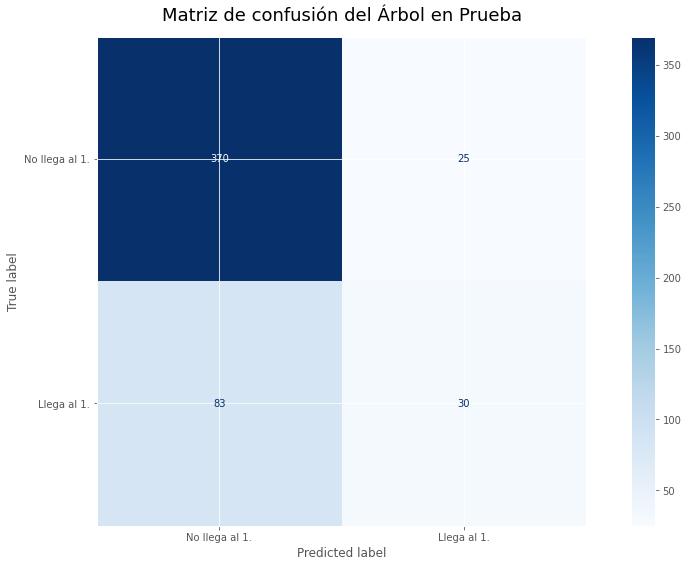

In [94]:
#Matriz de confuncipon para Test
disp = plot_confusion_matrix(gnb, X_train, y_train,
                                 display_labels=['No llega al 1.','Llega al 1.'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Matriz de confusión del Árbol en Prueba', y=1.02, size=18)

plt.show()

### Datos de prueba

c:\Users\User\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


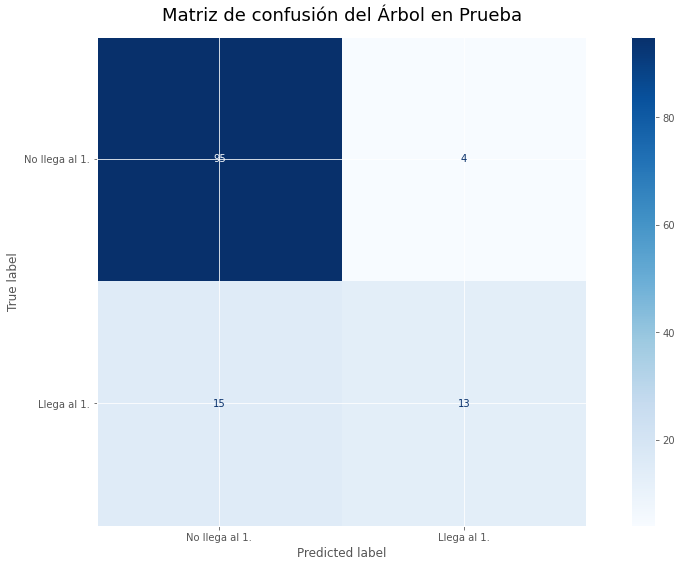

In [95]:
#Matriz de confuncipon para Test
disp = plot_confusion_matrix(gnb, X_test, y_test,
                                 display_labels=['No llega al 1.','Llega al 1.'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Matriz de confusión del Árbol en Prueba', y=1.02, size=18)

plt.show()

## Exactitud del árbol con datos de entrenamiento

In [96]:
y_pred_train = gnb.predict(X_train)

In [97]:
acc_train = accuracy_score(y_train, y_pred_train)
print("Train set accuracy: {:.2f}".format(acc_train))

Train set accuracy: 0.79


## Exactitud del árbol con datos de prueba

In [98]:
y_pred_test = gnb.predict(X_test)

In [99]:
acc_test = accuracy_score(y_test, y_pred_test)
print("Test set accuracy: {:.2f}".format(acc_test))

Test set accuracy: 0.85


## F1-Score, precision, recall

### Datos de entrenamiento

In [100]:
decoded_y_test = y_train
decoded_predictions = gnb.predict(X_train)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test,
                            decoded_predictions))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.82      0.94      0.87       395
           1       0.55      0.27      0.36       113

    accuracy                           0.79       508
   macro avg       0.68      0.60      0.61       508
weighted avg       0.76      0.79      0.76       508



### Datos de prueba

In [101]:
decoded_y_test = y_test
decoded_predictions = gnb.predict(X_test)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test,
                            decoded_predictions))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91        99
           1       0.76      0.46      0.58        28

    accuracy                           0.85       127
   macro avg       0.81      0.71      0.74       127
weighted avg       0.84      0.85      0.84       127



## Predicción de la clasificación bayesiana.

In [102]:
#predecir artista CAMILA CABELLO featuring YOUNG THUG
# con su canción Havana llego a numero 1 Billboard US en 2017

x_test = pd.DataFrame(columns=('top','moodEncoded', 'tempoEncoded', 'genreEncoded','artist_typeEncoded','edadEncoded','durationEncoded'))
x_test.loc[0] = (1,5,2,4,1,0,3)
y_pred = gnb.predict(x_test.drop(['top'], axis = 1)) #Saca el top: Característica objetivo
print("Prediccion: " + str(y_pred))
y_proba = gnb.predict_proba(x_test.drop(['top'], axis = 1))
print("Probabilidad de Acierto: " + str(np.round(y_proba[0][y_pred]* 100, 2)) + "%")

Prediccion: [1]
Probabilidad de Acierto: [66.96]%


In [103]:
#predecir artista Imagine Dragons 
# con su canción Believer llego al puesto 42 Billboard US en 2017

x_test = pd.DataFrame(columns=('top','moodEncoded', 'tempoEncoded', 'genreEncoded','artist_typeEncoded','edadEncoded','durationEncoded'))
x_test.loc[0] = (0,4,2,1,3,2,3)
y_pred = gnb.predict(x_test.drop(['top'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = gnb.predict_proba(x_test.drop(['top'], axis = 1))
print("Probabilidad de Acierto: " + str(np.round(y_proba[0][y_pred]* 100, 2))+"%")

Prediccion: [0]
Probabilidad de Acierto: [99.31]%


# Clasificación Bayesiana 2.
Se realizaron todos los preprocesamientos para aplicar los métodos.
SUPUESTOS (Ingenuidad): Para que los cálculos sean ligeros

- Los datos que se van a tratar provienen de una distribución Gaussiana.
- Los datos son independientes entre sí, es decir, cada una de forma individual aporta a la variable objetivo (Sin importar las otras).

In [338]:
import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib import colors
import matplotlib.pyplot as plt
 
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 9)
 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split

In [339]:
# carga de datos o teniendo el csv en la carpeta nube del colab.
#dataframe = pd.read_csv('comprar_alquilar.csv')
#dataframe.head()

In [ ]:
#Para abrir desde colab sin tenerlo en la nube.
#from google.colab import files
#import io
#uploaded = files.upload()
#dataframe = pd.read_csv(io.BytesIO(uploaded['comprar_alquilar.csv']))

Las columnas que tenemos son:

- *ingresos*: los ingresos mensuales de la familia
- *gastos comunes*: pagos de luz, agua, gas, etc mensual
- *pago coche*: si se está pagando cuota por uno o más coches, y los gastos en combustible, etc al mes.
- *gastos_otros*: compra en supermercado y lo necesario para vivir al mes
- *ahorros*: suma de ahorros dispuestos para usar en la compra de la casa.
- *vivienda*: precio de la vivienda que quiere comprar esa familia
- *estado civil*:
  0. soltero
  1. casados
  2. divorciados
- *hijos*: cantidad de hijos menores y que no trabajan.
- *trabajo*:
  0. sin empleo 
  1. autónomo (freelance)
  2. empleado
  3. empresario
  4. pareja: autónomos
  5. pareja: empleados
  6. pareja: autónomo y asalariado
  7. pareja:empresario y autónomo
  8. pareja: empresarios los dos o empresario y empleado
- comprar: (esta será nuestra columna de salida)
  0. Alquilar 
  1. Comprar 

### Algunos supuestos para el problema formulado:

- Está pensado en Euros pero podría ser cualquier otra moneda
- No tiene en cuenta ubicación geográfica (en la realidad esto afecta bastante el precio)
- Se supone una hipoteca fija a 30 años con interés de mercado «bajo».

## 0. Preprocesamiento.

In [ ]:
print(dataframe.groupby('comprar').size())
dataframe.shape

Tenemos 135 que dicen que se debe alquilar mientras solo 67 dicen que deben comprar

In [ ]:
dataframe.drop(['comprar'], axis=1).hist()
plt.show()

<center>

¿ Cuáles datos tienen distribución Gaussiana/Normal?
</center>

No olvidar los supuestos.

Se puede observar que los datos no se distribuyen exactamente normales... sin embargo, el '*Gaussian Naive Bayes Classifier*' asume:

 - Gausiana -> Asumimos que las muestras provienen de una distribución normal, para poder calcular la probabilidad P(B|A) usando la función de densidad de probabilidad normal

 - Ingenua -> Asumimos que las variables no están correlacionadas entre sí, cosa que rara vez es cierta.

### Añadir cálculos financieros que pueden ser de utilidad.

Procesando algunas de estas columnas podríamos agrupar los gastos. 

También crear una columna llamada financiar que será la resta del precio de la vivienda con los ahorros de la familia.

In [ ]:
dataframe['gastos']=(dataframe['gastos_comunes']+dataframe['gastos_otros']+dataframe['pago_coche'])
dataframe['financiar']=dataframe['vivienda']-dataframe['ahorros']
dataframe.drop(['gastos_comunes','gastos_otros','pago_coche'], axis=1).head(5)

Ahora usando el `describe()` de pandas podemos ver los estadisticos de los datos

In [ ]:
reduced = dataframe.drop(['gastos_comunes','gastos_otros','pago_coche','estado_civil','hijos','trabajo','comprar'], axis=1)
reduced.describe()

## 3. Variables claves para la clasificación

In [ ]:
X=dataframe.drop(['comprar'], axis=1)
y=dataframe['comprar']

best=SelectKBest(k=5)
X_new = best.fit_transform(X, y)
selected = best.get_support(indices=True)
print(X.columns[selected])
X_new.shape

<center>

Lo que deja por fuera 6 de las 11 variables que teniamos inicialmente y quedamos unicamente con las 5 que "mas aportan" al modelo de clasificación.
</center>

### Matriz de correlación. Observemos la correlación con el heatmap de correlación de Pearson

In [ ]:
used_features =X.columns[selected]
 
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sb.heatmap(dataframe[used_features].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='black', annot=True)

<center>

En general se ven poco correlacionadas, sin embargo tenemos 2 variables que se correlacionan fuertemente con otras 2 (2 valores de 0,7). Podria ser mejor buscar otra forma de codificacion para la variable trabajo ya que no tiene caracter ordinal (por ahora trabajaremos asi).
</center>

## 5. Definición del clasificador bayesiano.
Primero debemos dividir los datos de entrada entre entrenamiento y prueba, con 80% para entrenamiento y 20% para testeo.

In [ ]:
X = dataframe.drop(['comprar', 'gastos_comunes', 'pago_coche', 'gastos_otros', 'vivienda','estado_civil', 'gastos'], axis=1)
y = dataframe['comprar']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2)

In [ ]:
#Ajustando el modelo
# Instantiate the classifier
gnb = GaussianNB()
# Train classifier
gnb.fit(
    X_train,
    y_train
)
y_pred = gnb.predict(X_test)
 
print('Accuracy in training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy in test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))


## 6. Métricas y testeo del modelo.

### F1-Score, precision, recall

#### Datos de entrenamiento

In [ ]:
decoded_y_test = y_train
decoded_predictions = gnb.predict(X_train)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test,
                            decoded_predictions))

#### Datos de prueba

In [ ]:
decoded_y_test = y_test
decoded_predictions = gnb.predict(X_test)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test,
                            decoded_predictions))

In [ ]:
data = {'ingresos':[2000,6000,2000],
        'ahorros':[5000,34000,10000],
        'hijos':[0,2,1],
        'trabajo':[5,5,8],
        'financiar':[200000,320000,150000]}

prueba = pd.DataFrame(data)

In [ ]:
print(gnb.predict(prueba))

## Conclusiones

- **Pros**: Es rápido, simple de implementar, funciona bien con conjuntos de datos pequeños, va bien con muchas dimensiones (variables) y llega a dar buenos resultados aún siendo «ingenuo» sin que se cumplan todas las condiciones de distribución necesarias en los datos.

- **Contras**: Requiere quitar las dimensiones con correlación y para buenos resultados las entradas deberían cumplir las 2 suposiciones de distribución normal e independencia entre sí (muy difícil que sea así naturalmente, deberíamos hacer transformaciones en los datos de entrada).